# Exploratory Data Analysis for Recommender Systems

This notebook performs exploratory data analysis on recommendation system datasets. The goal is to understand the data and transform it into a graph-based representation (user-item-feature) that can be used for building a generic recommender system.

Dataset Links: 
- https://www.kaggle.com/datasets/parasharmanas/movie-recommendation-system?resource=download&select=movies.csv
- https://cseweb.ucsd.edu/~jmcauley/datasets.html (Steam reviews)

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

sns.set_style('whitegrid')

## Load Kaggle MovieLens Dataset

In [100]:
movies_df = pd.read_csv('datasets/movies/movies.csv')
ratings_df = pd.read_csv('datasets/movies/ratings.csv')

print('Movies Dataset:')
display(movies_df.head())

print('Ratings Dataset:')
display(ratings_df.head())

Movies Dataset:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Ratings Dataset:


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


### Explore Movies Data

In [101]:
print('Movies Info:')
movies_df.info()

Movies Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [102]:
print('Movies Description:')
display(movies_df.describe(include='all'))

Movies Description:


,movieId,title,genres
count,62423.000000,62423,62423
unique,NaN,62325,1639
top,NaN,The Void (2016),Drama
freq,NaN,2,9056
mean,122220.387646,NaN,NaN
std,63264.744844,NaN,NaN
min,1.000000,NaN,NaN
25%,82146.500000,NaN,NaN
50%,138022.000000,NaN,NaN
75%,173222.000000,NaN,NaN


### Explore Ratings Data

In [103]:
print('Ratings Info:')
ratings_df.info()

Ratings Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [104]:
print('Ratings Description:')
display(ratings_df.describe(include='all'))

Ratings Description:


,userId,movieId,rating,timestamp
count,2.500010e+07,2.500010e+07,2.500010e+07,2.500010e+07
mean,8.118928e+04,2.138798e+04,3.533854e+00,1.215601e+09
std,4.679172e+04,3.919886e+04,1.060744e+00,2.268758e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.196000e+03,3.000000e+00,1.011747e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.198868e+09
75%,1.215570e+05,8.623000e+03,4.000000e+00,1.447205e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


## Data Transformation and Knowledge Graph Creation

Here, we define a function to process the datasets into a common graph structure. This function will handle different rating scales and feature formats.

In [105]:
def transform_to_graph(ratings_df, movies_df, rating_threshold=4.0, dataset_name='MovieLens'):
    print(f"Original number of ratings: {len(ratings_df)}")
    recommended_df = ratings_df[ratings_df['rating'] >= rating_threshold].copy()
    print(f"Number of ratings after applying threshold (>= {rating_threshold}): {len(recommended_df)}")
    
    # Add a prefix to user and movie IDs to avoid collisions between datasets
    recommended_df['userId'] = f'{dataset_name}_user_' + recommended_df['userId'].astype(str)
    movies_df['movieId'] = f'{dataset_name}_item_' + movies_df['movieId'].astype(str)
    
    movies_df['genres'] = movies_df['genres'].str.split('|')
    
    user_nodes = recommended_df['userId'].unique()
    item_nodes = movies_df['movieId'].unique()
    
    user_item_edges = list(zip(recommended_df['userId'], f'{dataset_name}_item_' + recommended_df['movieId'].astype(str)))
    
    item_genre_edges = []
    genre_nodes = set()
    exploded_genres = movies_df.explode('genres')
    for _, row in exploded_genres.iterrows():
        genre = str(row['genres']).lower().replace(' ', '_')
        item_genre_edges.append((row['movieId'], genre))
        genre_nodes.add(genre)
            
    return {
        'user_nodes': list(user_nodes),
        'item_nodes': list(item_nodes),
        'genre_nodes': list(genre_nodes),
        'user_item_edges': user_item_edges,
        'item_genre_edges': item_genre_edges
    }

movielens_graph = transform_to_graph(ratings_df.copy(), movies_df.copy())

print(f"Number of user nodes: {len(movielens_graph['user_nodes'])}")
print(f"Number of item nodes: {len(movielens_graph['item_nodes'])}")
print(f"Number of genre nodes: {len(movielens_graph['genre_nodes'])}")
print(f"Number of user-item edges: {len(movielens_graph['user_item_edges'])}")
print(f"Number of item-genre edges: {len(movielens_graph['item_genre_edges'])}")

Original number of ratings: 25000095
Number of ratings after applying threshold (>= 4.0): 12452811
Number of user nodes: 162342
Number of item nodes: 62423
Number of genre nodes: 20
Number of user-item edges: 12452811
Number of item-genre edges: 112307


### Visualize the Graph

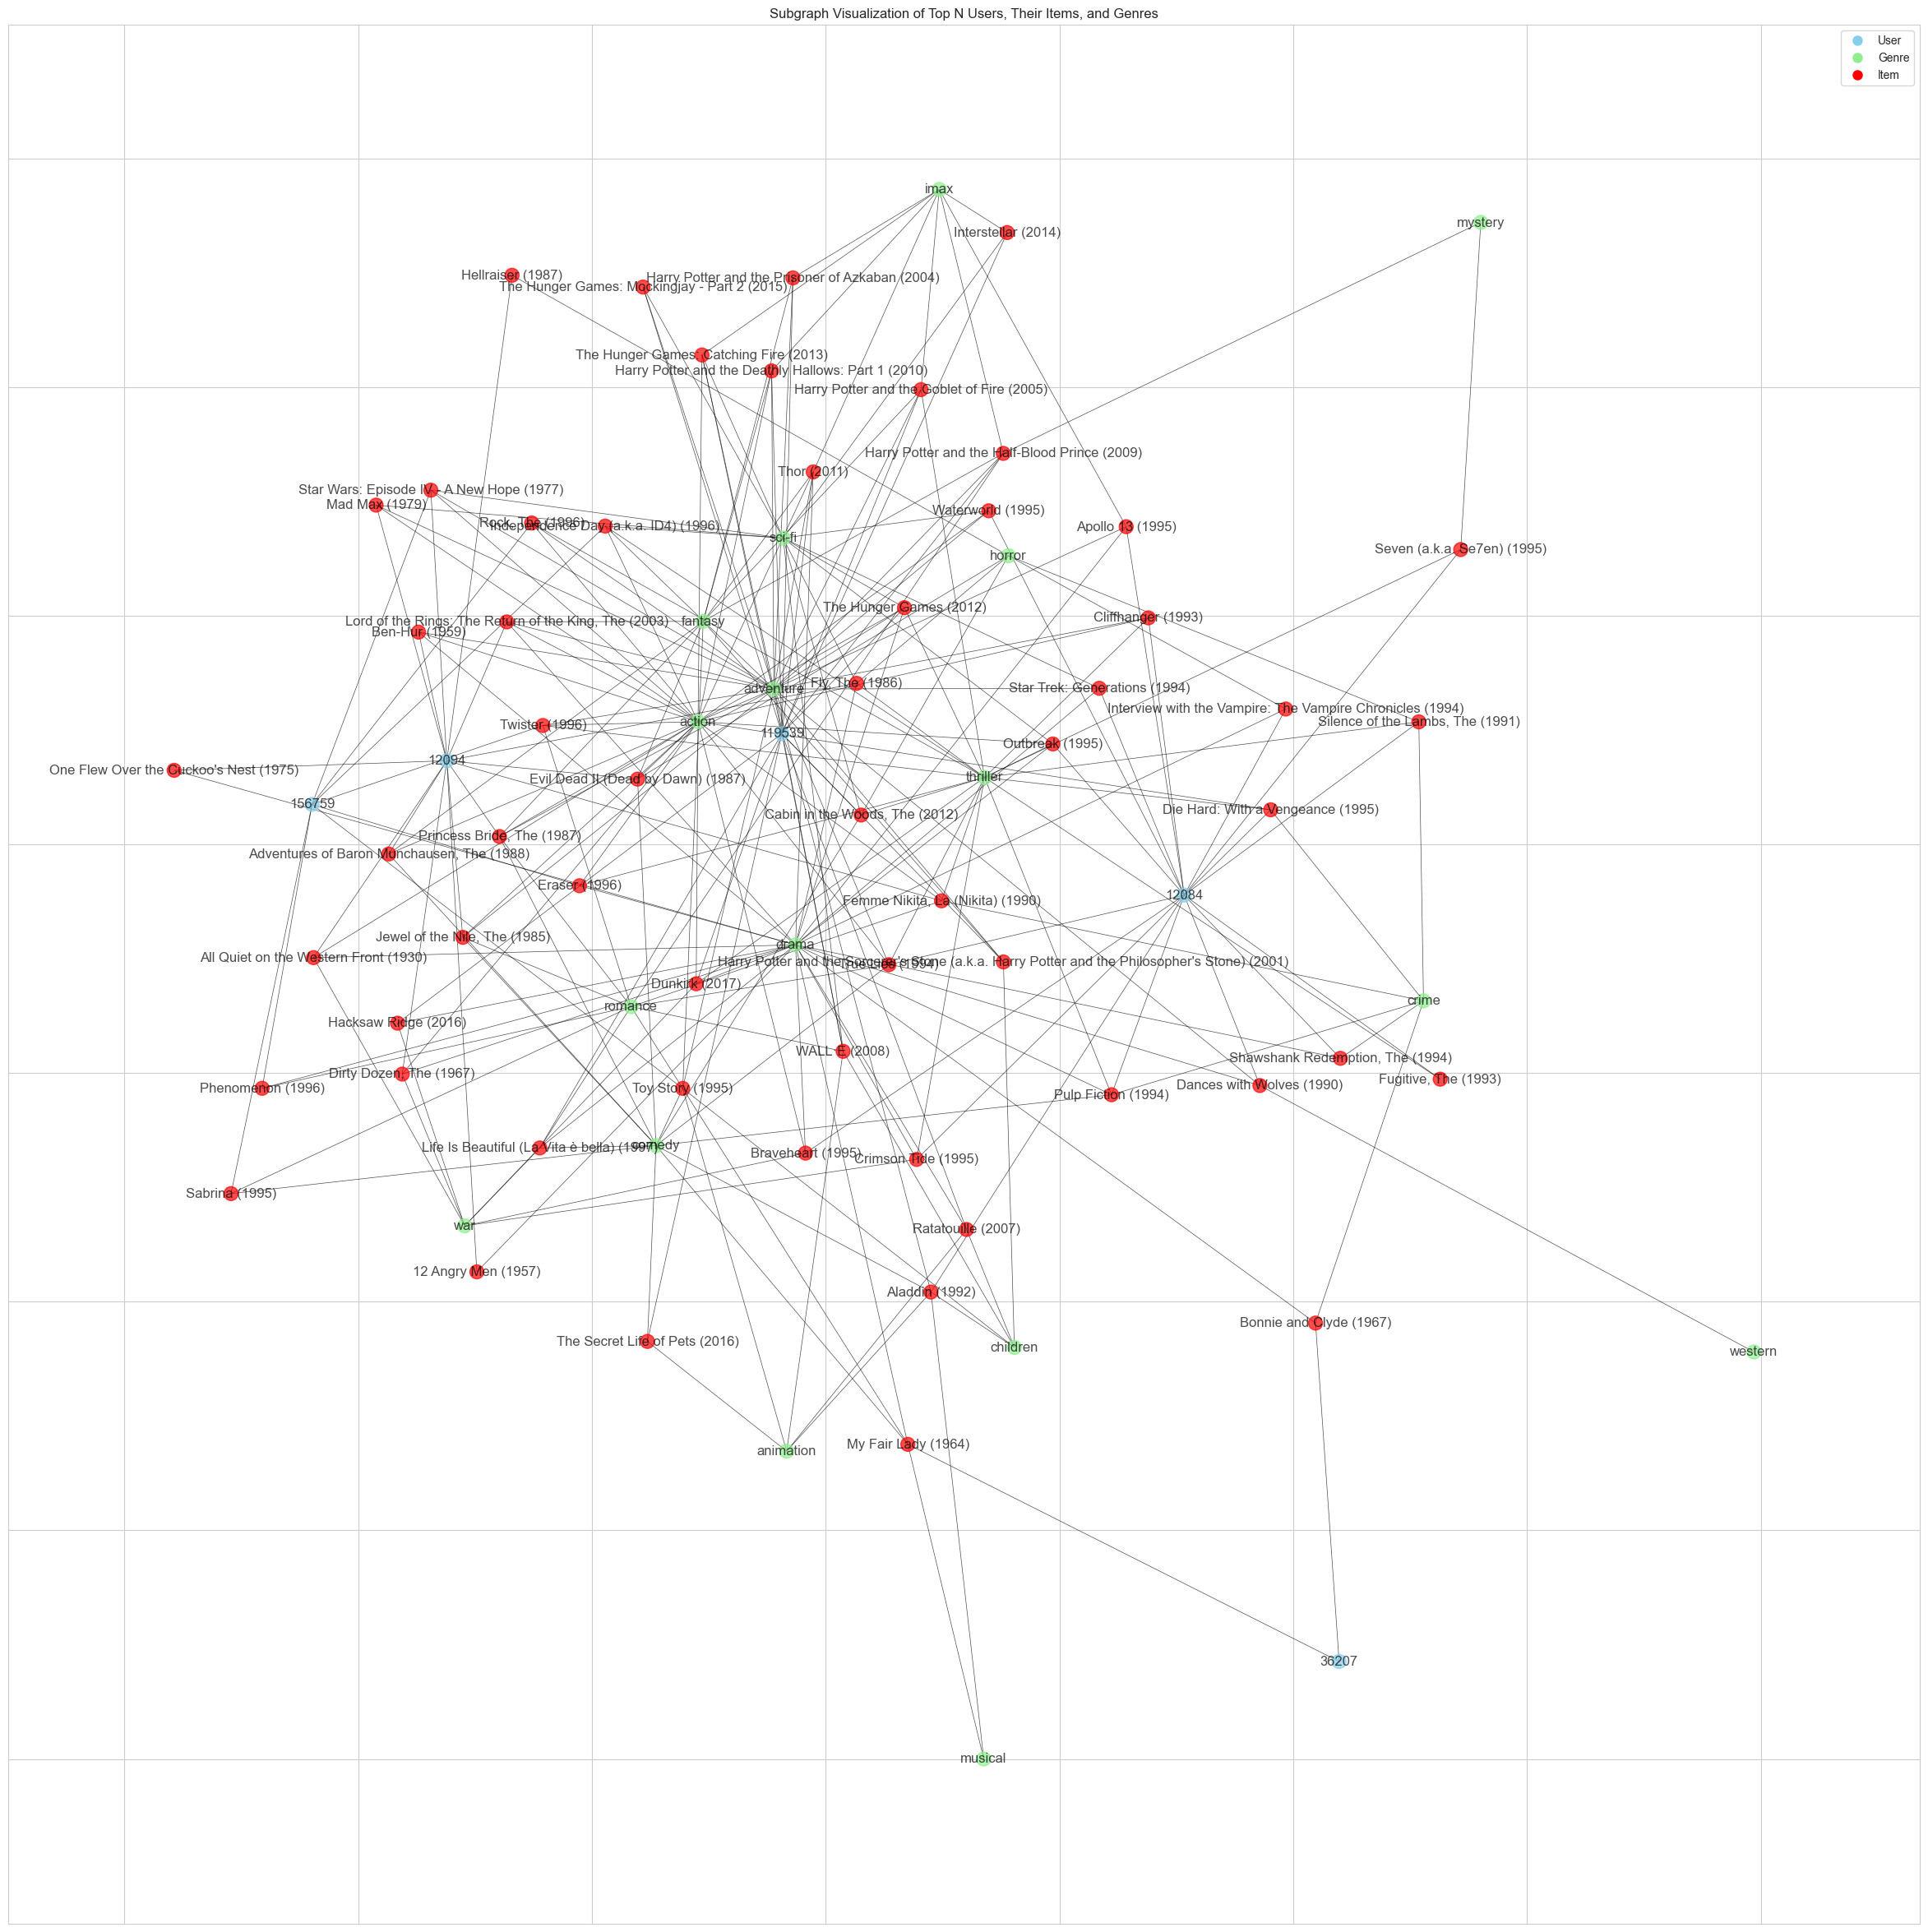

In [106]:
import networkx as nx

def draw_subgraph(graph, users_to_add, items_df, ratings_df):
    G = nx.Graph()
    
    G.add_nodes_from(users_to_add, type='user')
    
    items_to_add = set()
    user_item_edges_subset = [edge for edge in graph['user_item_edges'] if edge[0] in users_to_add]
    
    if not user_item_edges_subset:
        print("No item data to visualize for the selected users.")
        return

    for u, i in user_item_edges_subset:
        G.add_edge(u, i)
        items_to_add.add(i)
    G.add_nodes_from(list(items_to_add), type='item')
    
    genres_to_add = set()
    item_genre_edges_subset = [edge for edge in graph['item_genre_edges'] if edge[0] in items_to_add]
    for i, g in item_genre_edges_subset:
        G.add_edge(i, g)
        genres_to_add.add(g)
    G.add_nodes_from(list(genres_to_add), type='genre')

    labels = {}
    for node in G.nodes():
        node_type = G.nodes[node]['type']
        if node_type == 'user':
            labels[node] = node.split('_')[-1]
        elif node_type == 'item':
            item_id = int(node.split('_')[-1])
            title = ''
            if 'MovieLens' in node:
                title = items_df[items_df['movieId'] == item_id]['title'].iloc[0]
            elif 'Steam' in node:
                title= items_df[items_df['app_id'] == item_id]['title'].iloc[0]
            labels[node] = title
        elif node_type == 'genre':
            labels[node] = node

    plt.figure(figsize=(30, 30))
    
    pos = nx.spring_layout(G, k=0.15, iterations=40)
    
    node_colors = []
    for node in G.nodes():
        node_type = G.nodes[node]['type']
        if node_type == 'user':
            node_colors.append('skyblue')
        elif node_type == 'genre':
            node_colors.append('lightgreen')
        else:
            node_colors.append('red')
            
    nx.draw_networkx(G, pos, labels=labels, with_labels=True, node_size=150, node_color=node_colors, width=0.5, alpha=0.7)
    
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='User', markerfacecolor='skyblue', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Genre', markerfacecolor='lightgreen', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Item', markerfacecolor='red', markersize=10)]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title('Subgraph Visualization of Top N Users, Their Items, and Genres')
    plt.show()

user_activity = ratings_df['userId'].value_counts()
last_user_ids = user_activity[-5:].index
last_users_prefixed = [f'MovieLens_user_{uid}' for uid in last_user_ids]

draw_subgraph(movielens_graph, users_to_add=last_users_prefixed, items_df=movies_df, ratings_df=ratings_df)

## Load Steam Dataset

The Steam dataset is composed of two large JSON files. Due to their size, we will load them line by line into pandas DataFrames.

Final json files were created by conver_to_json.py file using all version 1 files and version 2: item metadat.

In [107]:
import json
import pandas as pd
import ast

try:
    reviews_df_steam = pd.read_json('datasets/steam/formatted_user_reviews.json')
    reviews_df_steam['app_id']= reviews_df_steam['app_id'].astype(int)
    
    items_df_steam = pd.read_json('datasets/steam/formatted_steam_games.json')
    items_df_steam = items_df_steam.dropna(subset=['app_id'])
    items_df_steam['app_id'] = items_df_steam['app_id'].astype(int)
    print("Steam datasets loaded successfully.")

    # Remove games with no title and genres
    items_df_steam_cleaned = items_df_steam.dropna(subset=['title', 'genres'], how='all')

    # Remove reviews for the removed games
    reviews_df_steam_cleaned = reviews_df_steam[reviews_df_steam['app_id'].isin(items_df_steam_cleaned["app_id"].tolist())]

    print("Cleaned Reviews Dataset:")
    display(reviews_df_steam_cleaned.head())
    print("Cleaned Items Dataset:")
    display(items_df_steam_cleaned.head())

except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please ensure the file paths are correct.")

Steam datasets loaded successfully.
Cleaned Reviews Dataset:


,user_id,app_id
0,76561197970982479,1250
1,76561197970982479,22200
4,js41637,227300
5,js41637,239030
6,evcentric,248820


Cleaned Items Dataset:


,app_id,title,genres
0,761140,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]"
1,643980,Ironbound,"[Free to Play, Indie, RPG, Strategy]"
2,670290,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]"
3,767400,弹炸人2222,"[Action, Adventure, Casual]"
5,772540,Battle Royale Trainer,"[Action, Adventure, Simulation]"


### Explore Steam Reviews Data

In [108]:
print('Steam Reviews Info:')
reviews_df_steam_cleaned.info()

print('Steam Reviews Description:')
display(reviews_df_steam_cleaned.describe(include='all'))

Steam Reviews Info:
<class 'pandas.core.frame.DataFrame'>
Index: 45261 entries, 0 to 52472
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  45261 non-null  object
 1   app_id   45261 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 884.0+ KB
Steam Reviews Description:


,user_id,app_id
count,45261,45261.000000
unique,22077,NaN
top,76561198064484479,NaN
freq,20,NaN
mean,NaN,162686.969643
std,NaN,133417.024333
min,NaN,10.000000
25%,NaN,4000.000000
50%,NaN,209160.000000
75%,NaN,257510.000000


### Explore Steam Items Data

In [109]:
print('Steam Items Info:')
items_df_steam_cleaned.info()

print('Steam Items Description:')
display(items_df_steam_cleaned.describe(include='all'))

Steam Items Info:
<class 'pandas.core.frame.DataFrame'>
Index: 30085 entries, 0 to 32133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   app_id  30085 non-null  int32 
 1   title   30084 non-null  object
 2   genres  28851 non-null  object
dtypes: int32(1), object(2)
memory usage: 822.6+ KB
Steam Items Description:


,app_id,title,genres
count,3.008500e+04,30084,28851
unique,NaN,30054,883
top,NaN,Soundtrack,[Action]
freq,NaN,3,1880
mean,4.440048e+05,NaN,NaN
std,1.842230e+05,NaN,NaN
min,1.000000e+01,NaN,NaN
25%,3.218300e+05,NaN,NaN
50%,4.383000e+05,NaN,NaN
75%,5.889700e+05,NaN,NaN


### Data Transformation for Steam Dataset

In [110]:
def transform_steam_to_graph(reviews_df, items_df, dataset_name='Steam'):
    # User-item edges from reviews
    user_item_edges = list(zip(f'{dataset_name}_user_' + reviews_df['user_id'].astype(str), f'{dataset_name}_item_' + reviews_df['app_id'].astype(str)))

    # Item-genre edges
    item_genre_edges = []
    genre_nodes = set()
    
    items_df_exploded = items_df.explode('genres')
    for _, row in items_df_exploded.iterrows():
        genre = genre = str(row['genres']).lower().replace(' ', '_')
        if genre:
            item_genre_edges.append((f"{dataset_name}_item_{row['app_id']}", genre))
            genre_nodes.add(genre)

    user_nodes = list(set([edge[0] for edge in user_item_edges]))
    item_nodes = list(set([edge[1] for edge in user_item_edges]))

    return {
        'user_nodes': user_nodes,
        'item_nodes': item_nodes,
        'genre_nodes': list(genre_nodes),
        'user_item_edges': user_item_edges,
        'item_genre_edges': item_genre_edges
    }

steam_graph = transform_steam_to_graph(reviews_df_steam_cleaned, items_df_steam_cleaned)

print(f"Number of user nodes: {len(steam_graph['user_nodes'])}")
print(f"Number of item nodes: {len(steam_graph['item_nodes'])}")
print(f"Number of genre nodes: {len(steam_graph['genre_nodes'])}")
print(f"Number of user-item edges: {len(steam_graph['user_item_edges'])}")
print(f"Number of item-genre edges: {len(steam_graph['item_genre_edges'])}")

Number of user nodes: 22077
Number of item nodes: 2802
Number of genre nodes: 23
Number of user-item edges: 45261
Number of item-genre edges: 72786


### Visualize the Steam Graph

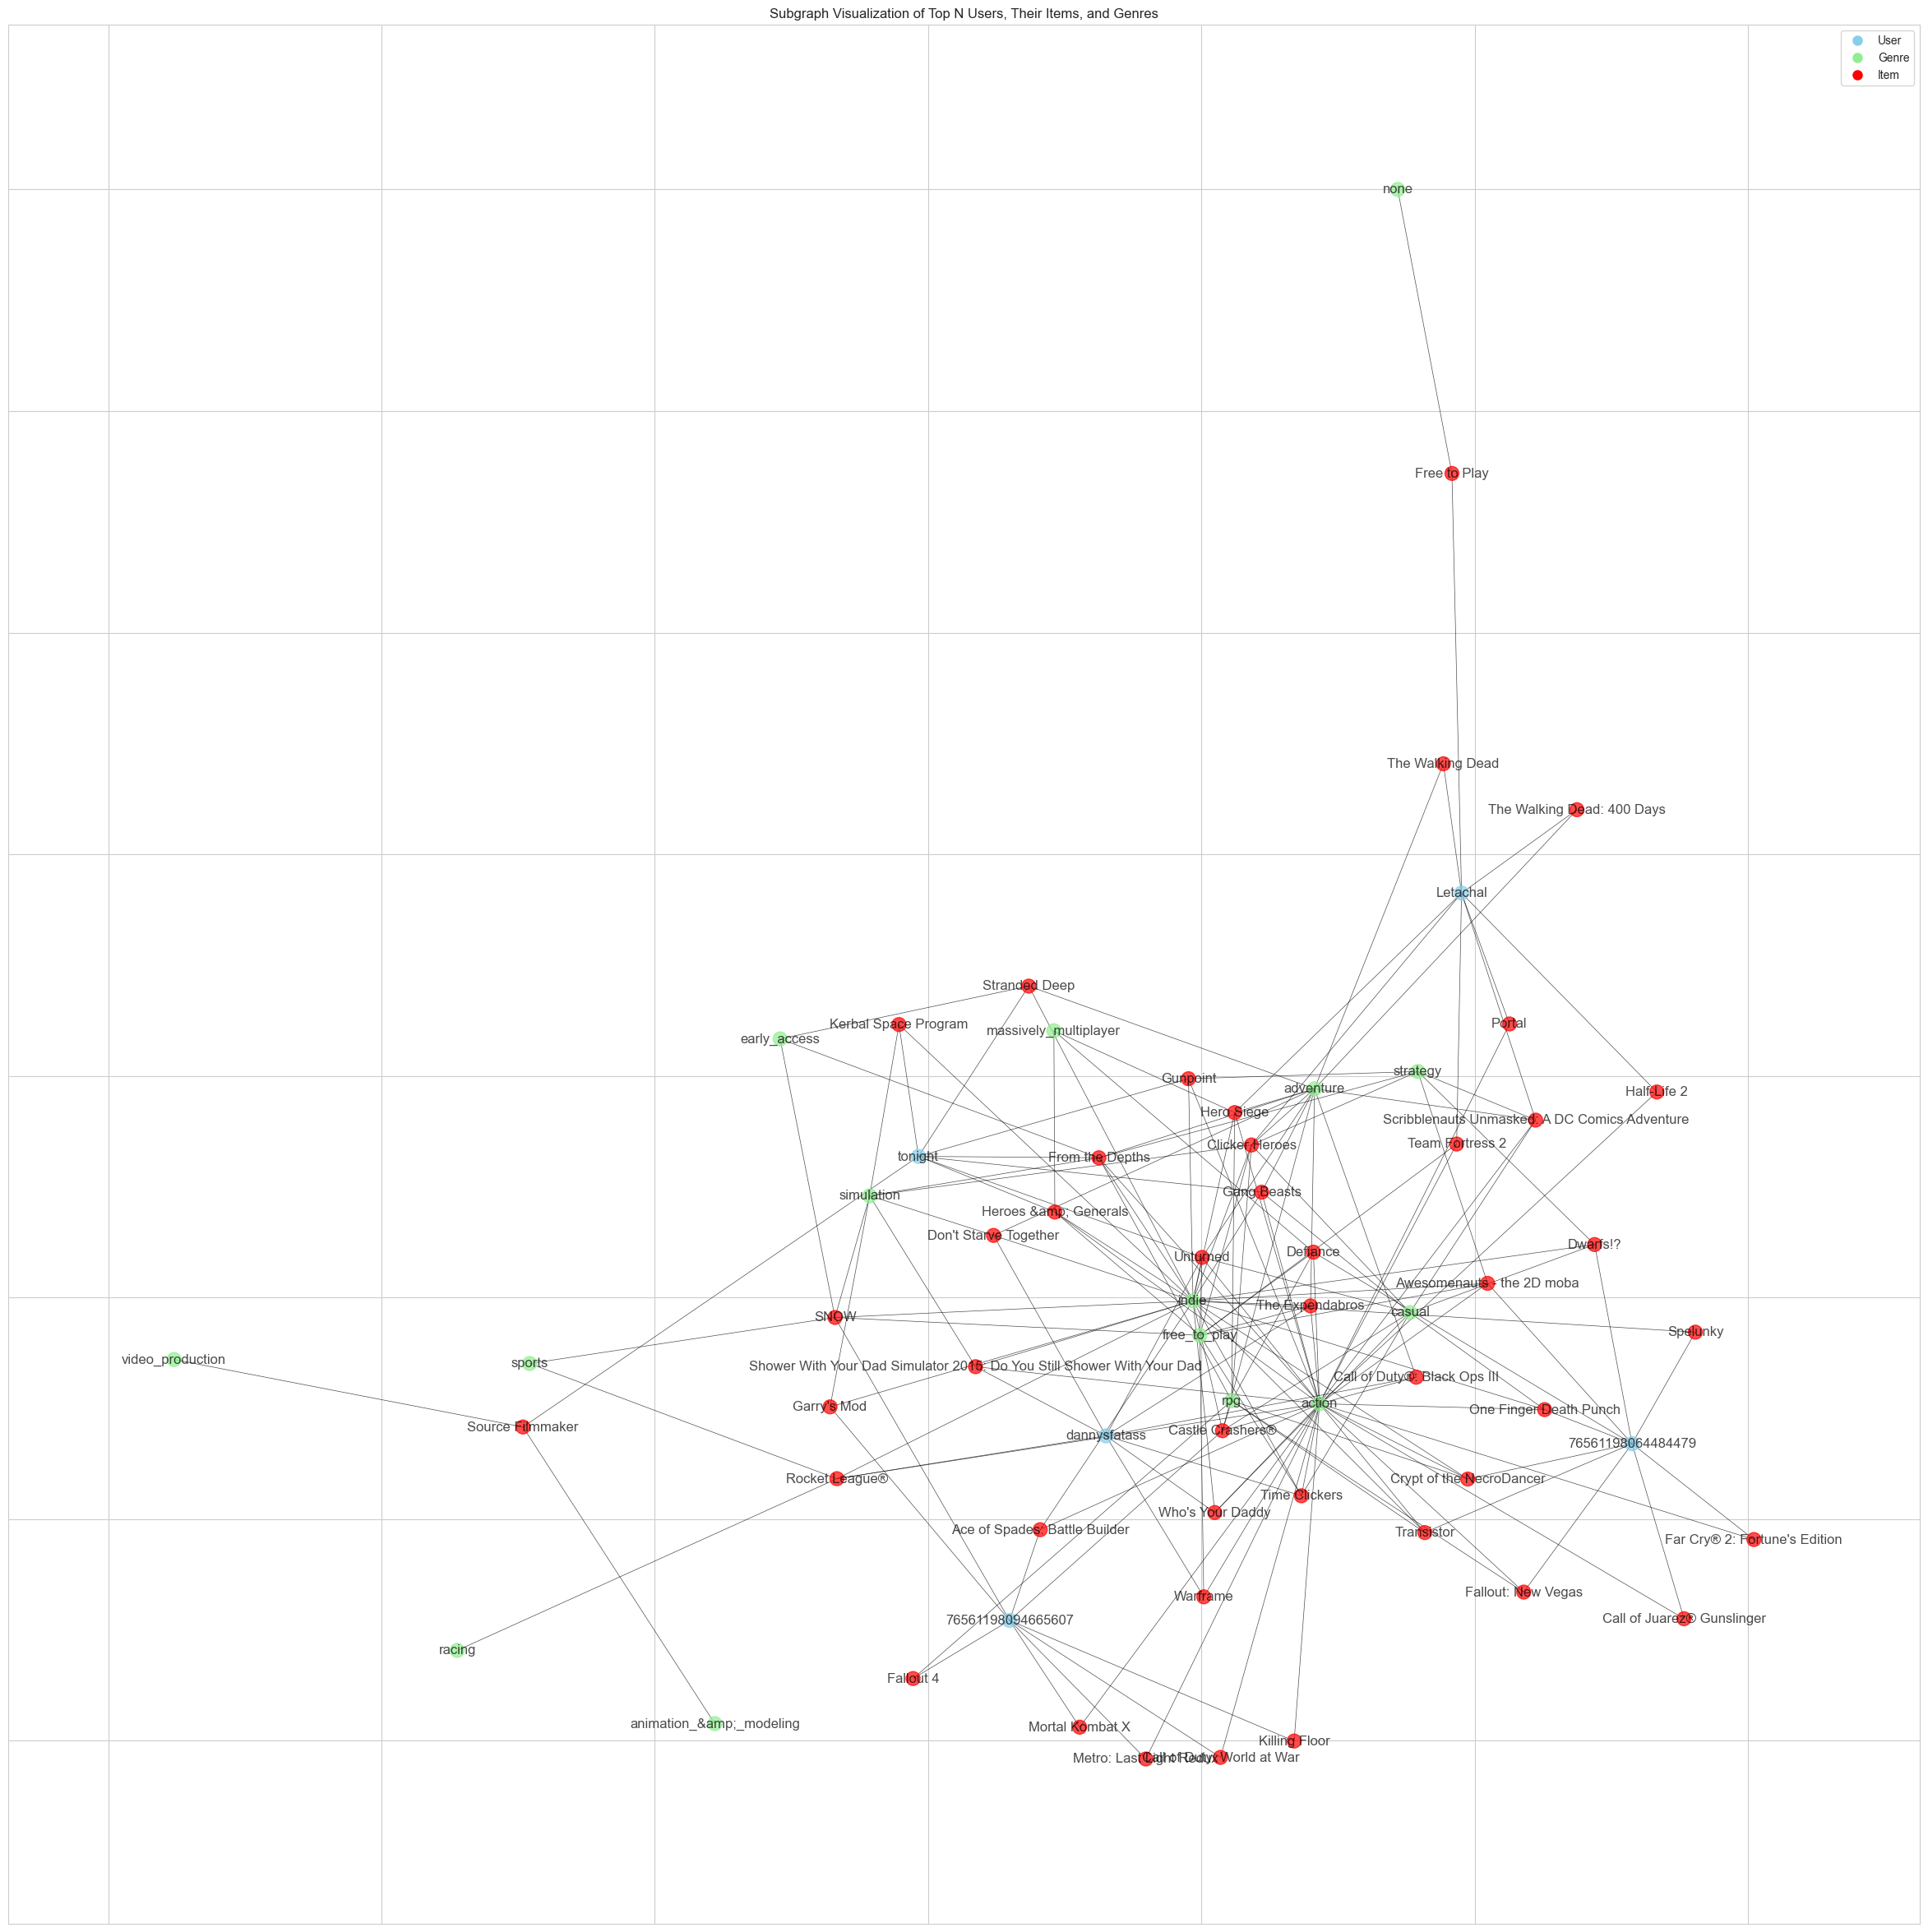

In [111]:
# Get a sample of users to visualize
steam_user_activity = pd.Series([edge[0] for edge in steam_graph['user_item_edges']]).value_counts()
top_steam_users = steam_user_activity.head(5).index

draw_subgraph(steam_graph, users_to_add=top_steam_users, items_df=items_df_steam_cleaned, ratings_df=reviews_df_steam_cleaned)

## Merge MovieLens and Steam Graphs

Now we will merge the two graphs to create a single, unified graph. This will allow us to see the connections between the two datasets.

Number of user nodes in merged graph: 184419
Number of item nodes in merged graph: 65225
Number of genre nodes in merged graph: 41
Number of user-item edges in merged graph: 12497401
Number of item-genre edges in merged graph: 185092


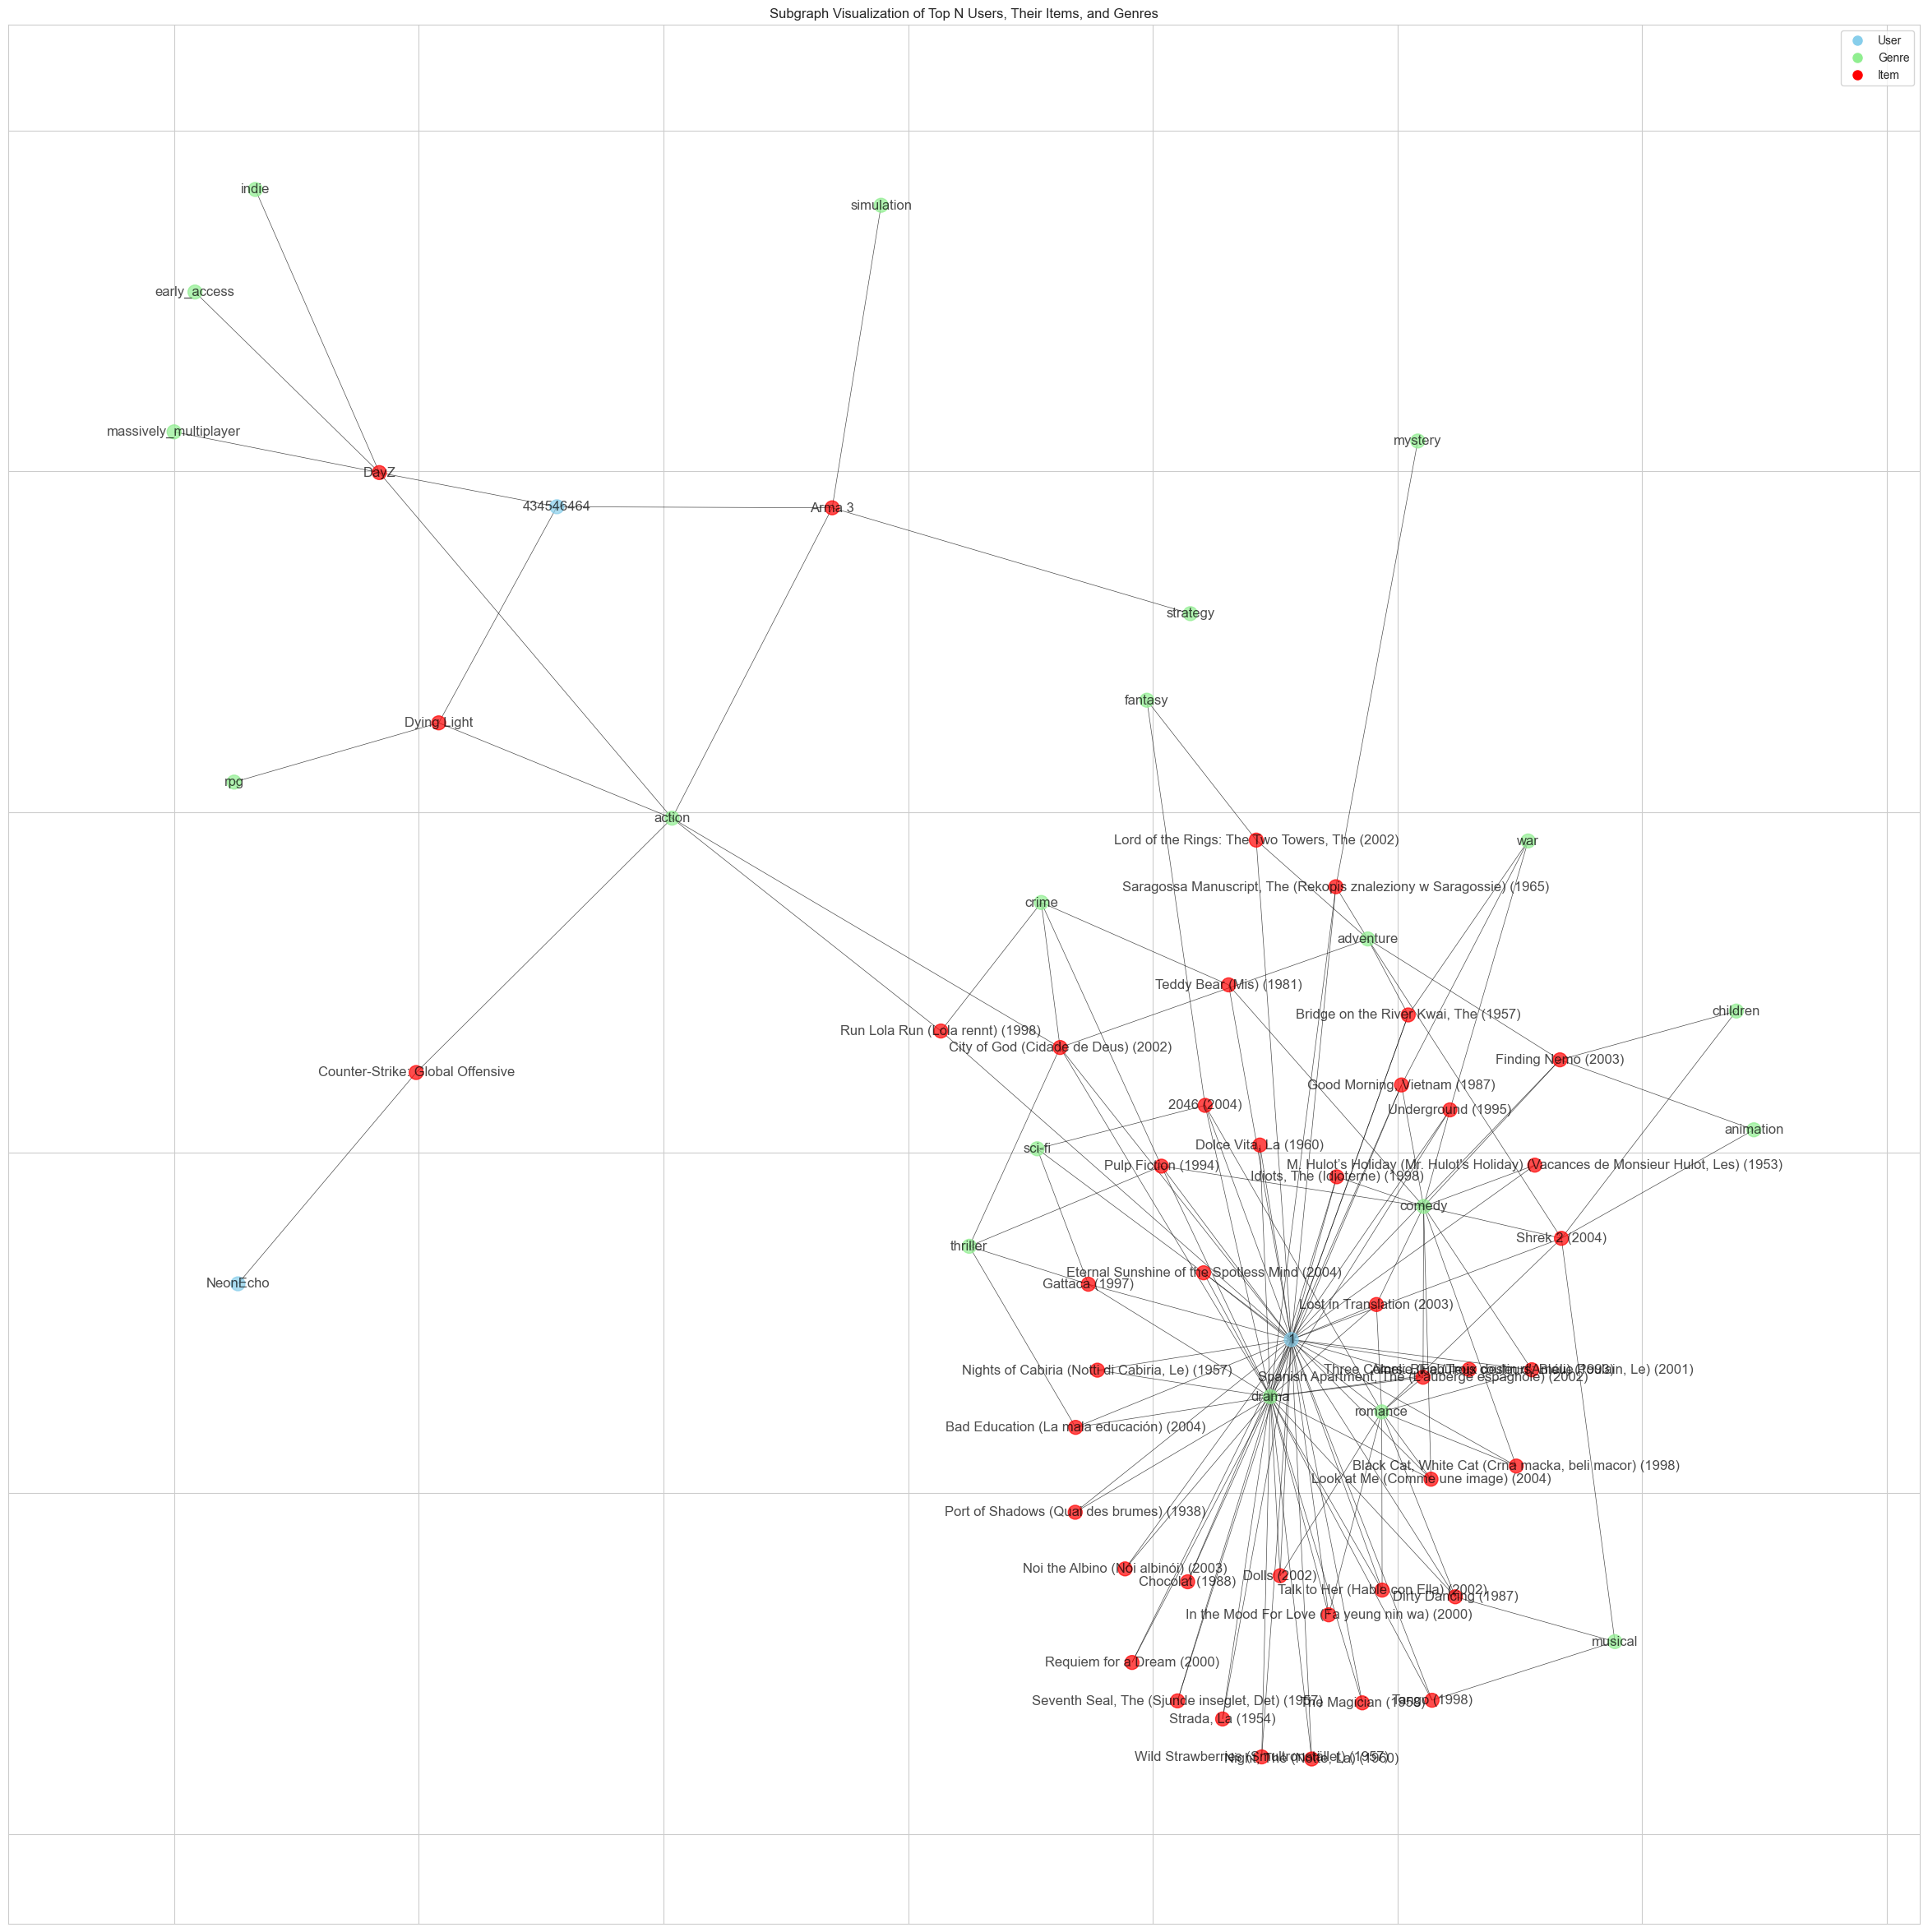

In [112]:
def merge_graphs(graph1, graph2):
    merged_graph = {
        'user_nodes': list(set(graph1['user_nodes'] + graph2['user_nodes'])),
        'item_nodes': list(set(graph1['item_nodes'] + graph2['item_nodes'])),
        'genre_nodes': list(set(graph1['genre_nodes'] + graph2['genre_nodes'])),
        'user_item_edges': list(set(graph1['user_item_edges'] + graph2['user_item_edges'])),
        'item_genre_edges': list(set(graph1['item_genre_edges'] + graph2['item_genre_edges']))
    }
    return merged_graph

merged_graph = merge_graphs(movielens_graph, steam_graph)

print(f"Number of user nodes in merged graph: {len(merged_graph['user_nodes'])}")
print(f"Number of item nodes in merged graph: {len(merged_graph['item_nodes'])}")
print(f"Number of genre nodes in merged graph: {len(merged_graph['genre_nodes'])}")
print(f"Number of user-item edges in merged graph: {len(merged_graph['user_item_edges'])}")
print(f"Number of item-genre edges in merged graph: {len(merged_graph['item_genre_edges'])}")

top_movielens_users = movielens_graph['user_nodes'][:1]
top_steam_users = steam_graph['user_nodes'][:2]
users_to_visualize = top_movielens_users + top_steam_users

all_items_df = pd.concat([movies_df, items_df_steam_cleaned])
all_ratings_df = pd.concat([ratings_df, reviews_df_steam_cleaned])

draw_subgraph(merged_graph, users_to_add=users_to_visualize, items_df=all_items_df, ratings_df=all_ratings_df)